# Inicialização

In [ ]:
import os
import sys
import time
import pandas as pd
import numpy as np
from pprint import pprint
import collections

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import axes3d
from matplotlib.transforms import Bbox
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from sklearn.base import clone



import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict,cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score,roc_curve,\
classification_report,confusion_matrix, ConfusionMatrixDisplay,mean_squared_error,r2_score,roc_auc_score,auc
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize


from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import seaborn as sns
from scipy import stats

from IPython.display import Image
pd.set_option('max_colwidth', 800)

In [2]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = True
ROOT_FOLDER = 'IC-TCC/experimentos' # only used if TEST_ON_COLAB is True
FOLDERNAME = 'rj/rj-es'

assert not (FOLDERNAME is None and ROOT_FOLDER is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"

In [81]:
if TEST_ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive

    drive.mount("/content/drive")
    data_path = f"/content/drive/MyDrive/{ROOT_FOLDER}/{FOLDERNAME}"
else:
    data_path = f"analysis/{FOLDERNAME}"

os.makedirs(data_path, exist_ok=True)
result_path=f"{data_path}/results"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import de Dados

In [172]:
latency_timeseries   = np.loadtxt(f"{data_path}/routes_latency.txt", comments='#')
routes_label   = np.loadtxt(f"{data_path}/routes_label.txt", comments='#', dtype=int)

timestamps = latency_timeseries[:, 0]
routes_latency = latency_timeseries[:, 1:]

In [175]:
'''
Essa função elimina outliers
Não usei no caso salvo, uma vez que estava retornando apenas 1 label de saída (sempre o caminho 1)
'''

# def remove_outliers_iqr(data, factor=2):
#     """Remove outliers usando método IQR"""
#     mask = np.ones(len(data), dtype=bool)

#     for col in range(data.shape[1]):
#         Q1 = np.percentile(data[:, col], 25)
#         Q3 = np.percentile(data[:, col], 75)
#         IQR = Q3 - Q1
#         lower = Q1 - factor * IQR
#         upper = Q3 + factor * IQR
#         mask &= (data[:, col] >= lower) & (data[:, col] <= upper)

#     return data[mask], mask

# # Aplicar limpeza
# routes_latency_clean, mask_clean = remove_outliers_iqr(routes_latency)
# timestamps_clean = timestamps[mask_clean]
# routes_label_clean = routes_label[mask_clean]

# print(f"Linhas originais: {len(routes_latency)}")
# print(f"Linhas após limpeza: {len(routes_latency_clean)}")
# print(f"Removidos: {len(routes_latency) - len(routes_latency_clean)}")

# routes_latency = routes_latency_clean
# routes_label = routes_label_clean
# timestamps = timestamps_clean

In [173]:
print(f"Shape: {routes_latency.shape}")
print("Primeiras linhas:")
print(routes_latency[:5])

X_train, X_test, y_train, y_test = train_test_split(routes_latency,
                                                    routes_label,
                                                    test_size=0.2,
                                                    random_state=1234,
                                                    shuffle=True, stratify=None)

Shape: (1326, 3)
Primeiras linhas:
[[ 7.  12.2  8.5]
 [ 7.  12.2  8.5]
 [ 7.1 12.2  8.5]
 [ 7.1 12.2  8.5]
 [ 7.  12.2  8.5]]


## Setup de plotagem de gráficos

In [146]:
routes_class = {'Caminho 1':1,'Caminho 2':2, 'Caminho 3': 3}

# plots saving/showing configurations
save_file_flag=True
show_IV_plot=True

In [147]:
# function to return key for any value

def get_key(val,mydict):

	for key, value in mydict.items():
		if val == value:
			return key

def count_label(labels,labels_dic):
    label_buf=collections.Counter(labels)
    counted_labels_dic={get_key(key1,labels_dic):value1 for key1,value1 in label_buf.items()}
    return counted_labels_dic

In [148]:
def lines_plot(df_i,save_path,title_str='',y_label='',x_label='',save_file=''):

    fig=plt.figure()
    for key in df_i.keys():
        plt.plot(np.arange(len(df_i[key])),df_i[key],marker='x',label=key)
    plt.xticks(np.arange(len(df_i[key])),list(map(str,np.arange(1,len(df_i[key])+1,1))))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title_str)
    #plt.legend(loc="best",bbox_to_anchor=(0.6, 0.4), ncol=2)
    plt.legend(loc="best")
    plt.grid()
    if save_file:
         plt.savefig(f"{os.path.join(save_path, save_file)}", dpi=300, format='pdf', bbox_inches='tight')
    plt.show()


def create_boxplot(valu_vec,save_path,date_set,title_str='',y_label='',x_label='',save_file=''):

    meanpointprops = dict(marker='+', markeredgecolor='darkgoldenrod',markerfacecolor='red')
    medianprops = dict(linestyle='-', linewidth=1, color='red')

    pltbx=plt.boxplot(valu_vec, showfliers=False,labels=date_set,meanprops=meanpointprops,medianprops=medianprops,
            showmeans=True,patch_artist=True)
    means_vals = [item.get_ydata()[0] for item in pltbx['means']]
    plt.setp(pltbx['boxes'], color='blue',facecolor='white')
    plt.title("%s"%title_str)
    #plt.ylim(0,10)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #plt.xticks(rotation = 45)
    legend_elements = [Line2D([0], [0], color='red', lw=1, label='Median'),
                    Line2D([0], [0], color='darkgoldenrod',marker='+',label='Mean'),
                  Line2D([0], [0], color='blue', lw=1, label='25%-75%'),
                   Line2D([0], [0], color='black', lw=1, label='9%-91%')]
    plt.legend(handles=legend_elements,loc='best',  fancybox=True, framealpha=1)
    plt.grid()
    if save_file:
         plt.savefig(f"{os.path.join(save_path, save_file)}", dpi=300, format='pdf', bbox_inches='tight')
    plt.show()
    return means_vals

#####################################################################################################################

def call_compute_color_position(ax,confusion_mat):
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='large')
    ax.tick_params(top=False, bottom=True,labeltop=False, labelbottom=True)
    #ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)
    return ax

def plot_matrix(conf_mat,class_labels,classifier,title_str='',save_path='',save_file=''):

    fig = plt.figure()
    axes = fig.add_subplot(111)
    cax=axes.matshow(conf_mat, cmap=plt.cm.YlGnBu, alpha=0.8)
    fig.colorbar(cax)
    axes=call_compute_color_position(axes,conf_mat)
    axes.set_xlabel('Predictions')
    axes.set_ylabel('Actuals')
    axes.set_title(f'{title_str}',fontsize=10)
    axes.set_xticklabels([''] + class_labels)
    axes.set_yticklabels([''] + class_labels)
    if save_file:
        file_to_save=f"{save_file}_{classifier}.pdf"
        plt.savefig(f"{os.path.join(save_path, file_to_save)}", dpi=300, bbox_inches='tight')
    plt.show()


In [223]:
def plot_roc_curve(y_test_binarized,class_labels,classifier,y_pred_proba,title_str='',save_path='',save_file=''):

    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}
    roc_auc = dict()

    n_class = len(class_labels)

    for i in range(n_class):
        # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[i], y_pred_proba[:,i])
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i]) # multiclasse
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plotting
        plt.plot(fpr[i], tpr[i], linestyle='--',
                 label='%s vs Others (AUC=%0.2f)'%(class_labels[i],roc_auc[i]))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_class

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle="-.",linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle="-.",linewidth=2)


    plt.plot([0,1],[0,1], color='black',linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    #plt.title(f"{title_str}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='lower right')
    if save_file:
        file_to_save=f"{save_file}_{classifier}.pdf"
        plt.savefig(f"{os.path.join(save_path, file_to_save)}", dpi=300, bbox_inches='tight')
    plt.show()

In [150]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(0.98 + pad, 1.12 + pad)



def plot_Prob_Dist_OvR(class_labels,classifier,y_pred_proba,y_target,title_str='',save_path='',save_file=''):
    fig=plt.figure(figsize = (15, 4))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}
    prob_class_dic={}
    i=0
    for key,value in class_labels.items():
        class_binary = [1 if y == value else 0 for y in y_target]

        # Prepares an auxiliar dataframe to help with the plots
        prob_class_dic['class'] = class_binary
        prob_class_dic['prob'] = y_pred_proba[:, i]
        df_aux=pd.DataFrame(prob_class_dic)
        df_aux = df_aux.reset_index(drop = True)


        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(1, 4, i+1)
        #fig=sns.histplot(x='prob',data = df_aux, color = 'b', hue = 'class',ax = ax, bins = bins).get_figure()
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        sns.histplot(x='prob',data = df_aux, color = 'b', hue = 'class',ax = ax, bins = bins)
        #ax.set_title(value)
        ax.legend([f"Class: {key}", "Rest"])
        ax.set_xlabel(f"P(x = {key})")
        i=i+1
        if save_file:
            extent = full_extent(ax).transformed(fig.dpi_scale_trans.inverted())
            file_to_save=f"{save_file}_{classifier}_{key}.pdf"
            fig.savefig(f"{os.path.join(save_path, file_to_save)}", dpi=350,bbox_inches=extent)

    plt.tight_layout()
    plt.show()

## Ambiente de avaliação dos modelos

In [201]:
def modelCrossVal(X_train, y_train,folds=5,binary_classification=True):

    log_reg = LogisticRegression()
    knn = KNeighborsClassifier()
    svmsvc = svm.SVC(probability=True)
    dt = tree.DecisionTreeClassifier()
    et = ExtraTreesClassifier()
    rf = RandomForestClassifier()
    gnb = GaussianNB()

    cv_df= pd.DataFrame(columns=['Model','Acc.avg','Acc.std','roc_auc_score'])

    pipelines=[]
    y_pred_dic= {}
    y_predproba_dic= {}
    confusion_matrix_dic={}
    clfs = [
            ('LogisticRegression', log_reg),
            ('KNeighbors', knn),
            ('svc', svmsvc),
            ('DecisionTree', dt),
            ('ExtraTrees', et),
            ('RandomForest', rf),
            ('GaussianNB', gnb)
            ]

    for clf_name, clf in clfs:

        pipeline = Pipeline(steps=[
                                  ('classifier', clf)
                                  ]
                           )

        scores=cross_val_score(pipeline, X_train, y_train, cv=folds,scoring='accuracy')

        y_pred = cross_val_predict(pipeline, X_train, y_train, cv=folds, method='predict')
        y_predproba = cross_val_predict(pipeline, X_train, y_train, cv=folds, method='predict_proba')
        cm=confusion_matrix(y_train, y_pred)
        #print("roc_auc_score clf.predict_proba ",roc_auc_score(y_train, y_predproba, multi_class='ovr'))
        if binary_classification:
            roc_auc_score_value=roc_auc_score(y_train, y_predproba[:, 1],average="macro")
        else:
            roc_auc_score_value=roc_auc_score(y_train, y_predproba, multi_class='ovr',average="macro")

        # cv_df = cv_df.append({
        #                       'Model' : clf_name,
        #                       'Acc.avg':"%0.3f" %(scores.mean()),
        #                       'Acc.std':"%0.3f" %(scores.std()),
        #                       'roc_auc_score':"%0.3f" %(roc_auc_score_value)
        #                                   },
        #                                  ignore_index=True)

        new_row = pd.DataFrame([{
            'Model': clf_name,
            'Acc.avg': "%0.3f" % (scores.mean()),
            'Acc.std': "%0.3f" % (scores.std()),
            'roc_auc_score': "%0.3f" % (roc_auc_score_value)
        }])
        cv_df = pd.concat([cv_df, new_row], ignore_index=True)

        pipelines.append(pipeline)
        confusion_matrix_dic[clf_name]=cm
        y_pred_dic[clf_name]=y_pred
        y_predproba_dic[clf_name]=y_predproba
    return cv_df,y_pred_dic,y_predproba_dic,confusion_matrix_dic,pipelines

# Análise do dataset

In [174]:
d = {  'class_label': pd.Series(routes_label),
	   'routes_latency': pd.Series(routes_latency.tolist()) }

df = pd.DataFrame(d)

qtd_leituras = df.shape[0]

print(df['class_label'].value_counts())
print(routes_latency.shape)
print(routes_label.shape)
print(qtd_leituras)

class_label
1    1277
3      47
2       2
Name: count, dtype: int64
(1326, 3)
(1326,)
1326


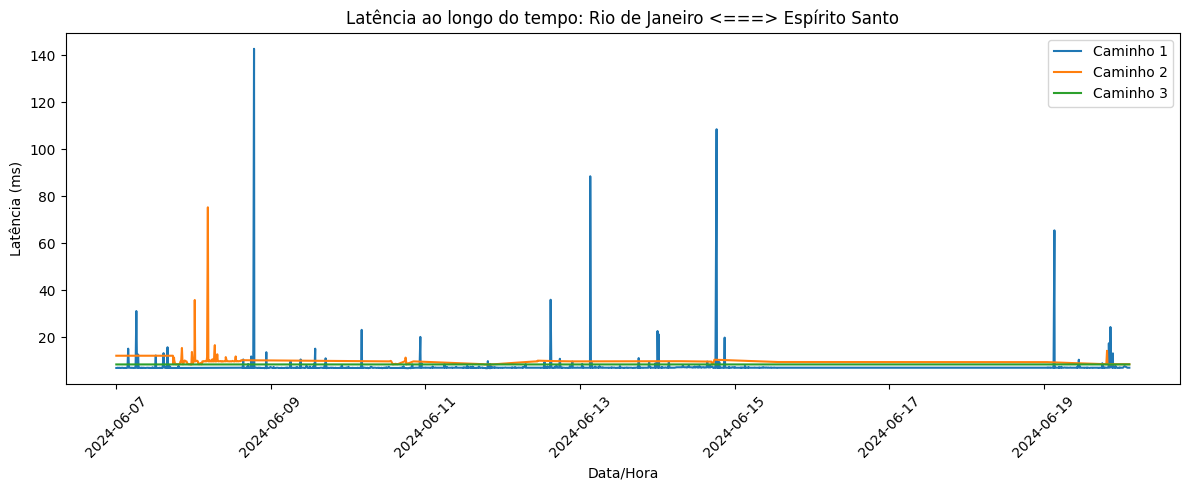

In [176]:
dates = pd.to_datetime(timestamps, unit='s')

fig = plt.figure(figsize=(12, 5))
plt.plot(dates, routes_latency[:, 0], label='Caminho 1')
plt.plot(dates, routes_latency[:, 1], label='Caminho 2')
plt.plot(dates, routes_latency[:, 2], label='Caminho 3')
plt.legend()
plt.xlabel('Data/Hora')
plt.ylabel('Latência (ms)')
plt.title('Latência ao longo do tempo: Rio de Janeiro <===> Espírito Santo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Validação cruzada dos modelos

In [199]:
y = routes_label

print("Distribuição das classes:")
print(pd.Series(y).value_counts())
print(f"\nTotal de amostras: {len(y)}")
print(f"Classes únicas: {np.unique(y)}")

Distribuição das classes:
1    1277
3      47
2       2
Name: count, dtype: int64

Total de amostras: 1326
Classes únicas: [1 2 3]


In [205]:
# print("\n###########     Full dataset      #################\n")
cross_val_scores_df2, y_pred_dic, y_predproba_dic, confusion_matrix_dic, pipelines = modelCrossVal(routes_latency, routes_label, folds=5, binary_classification=False)
pprint(cross_val_scores_df2)


###########     Full dataset      #################

                Model Acc.avg Acc.std roc_auc_score
0  LogisticRegression   0.996   0.004         0.998
1          KNeighbors   0.995   0.003         0.916
2                 svc   0.993   0.006         0.990
3        DecisionTree   0.995   0.007         0.981
4          ExtraTrees   0.991   0.009         0.999
5        RandomForest   0.997   0.003         0.999
6          GaussianNB   0.982   0.005         0.830


### Matriz de confusão

##############    LogisticRegression    ################


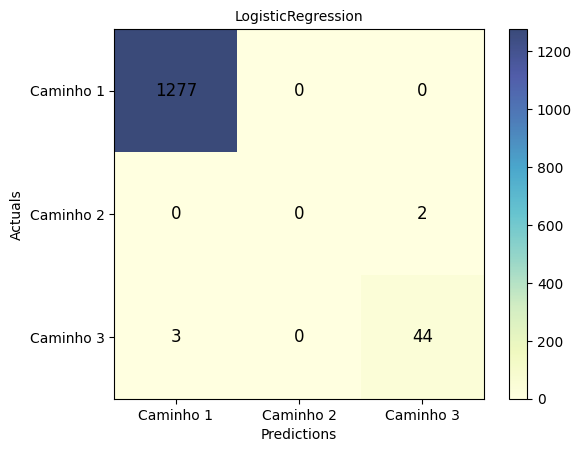

##############    KNeighbors    ################


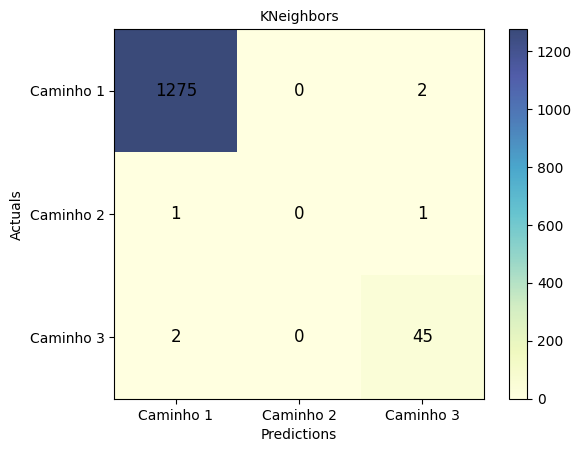

##############    svc    ################


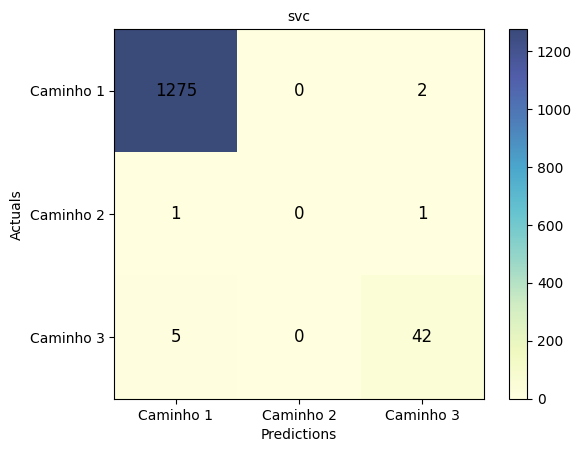

##############    DecisionTree    ################


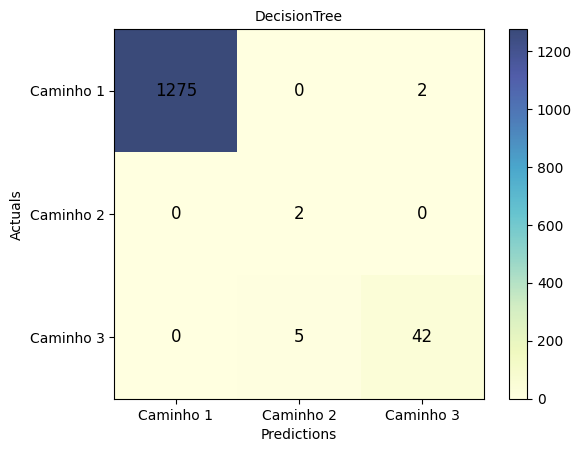

##############    ExtraTrees    ################


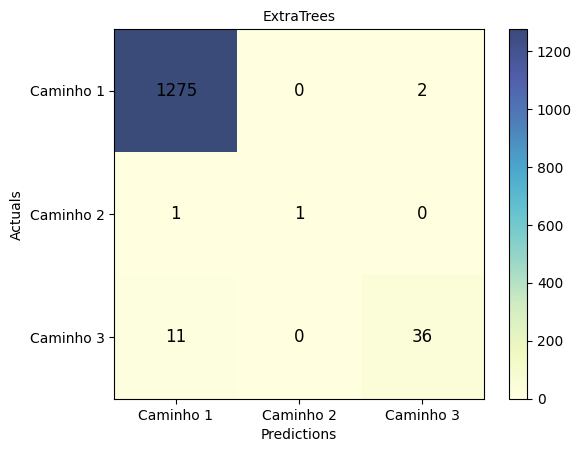

##############    RandomForest    ################


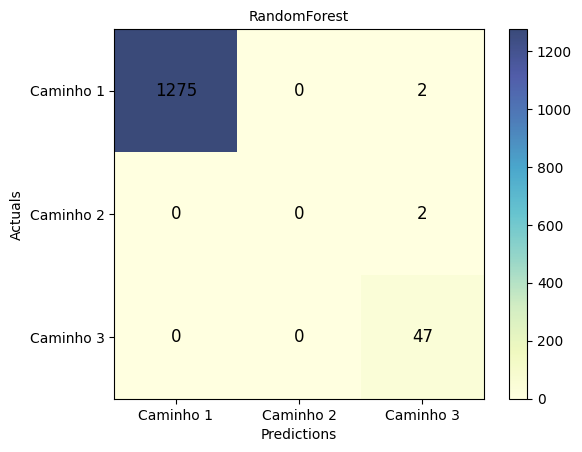

##############    GaussianNB    ################


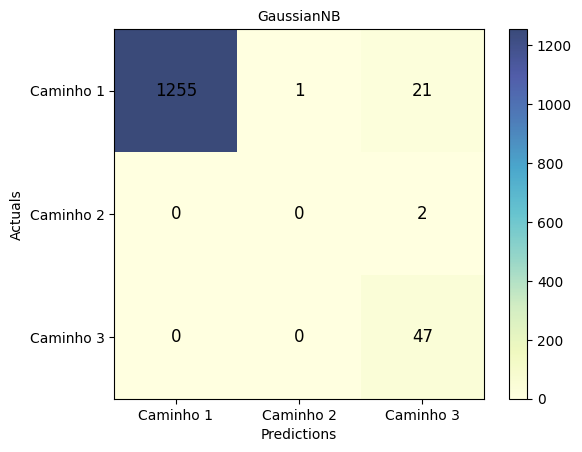

In [209]:
for key, values in confusion_matrix_dic.items():
    print(f"##############    {key}    ################")
    plot_matrix(confusion_matrix_dic[key],list(routes_class.keys()),key,title_str=key,save_path=result_path,save_file='cross_val_cm')

## Probability Distribution

##############    LogisticRegression    ################


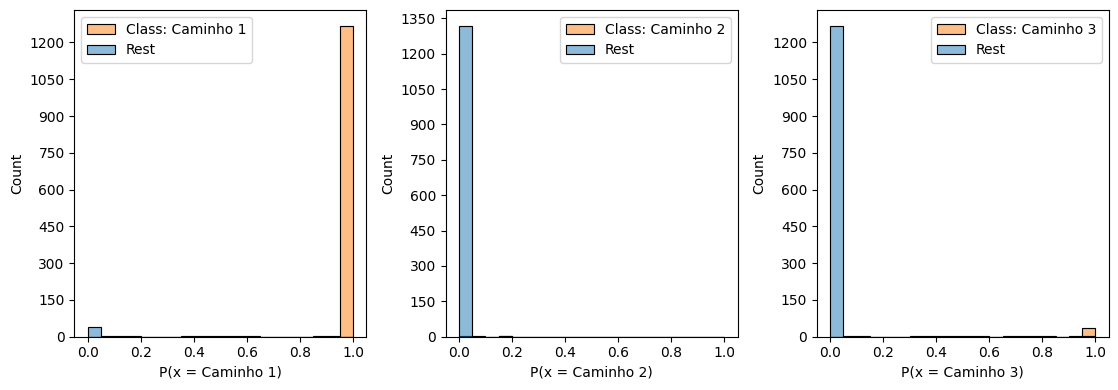

##############    KNeighbors    ################


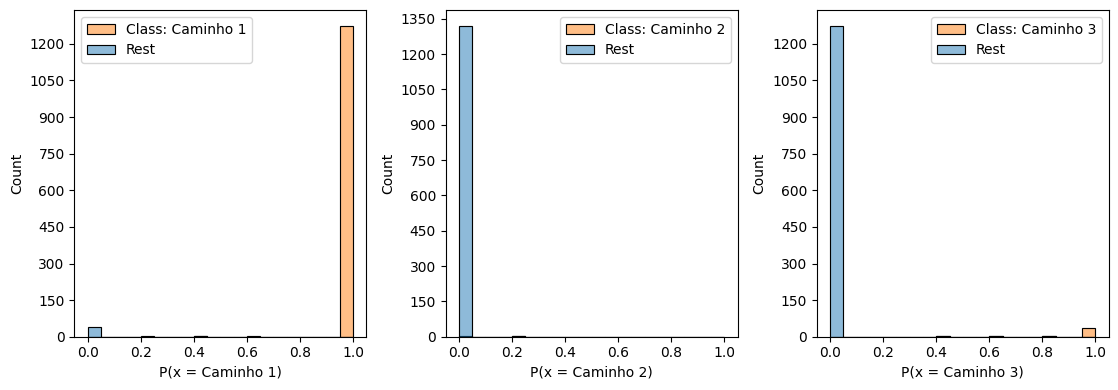

##############    svc    ################


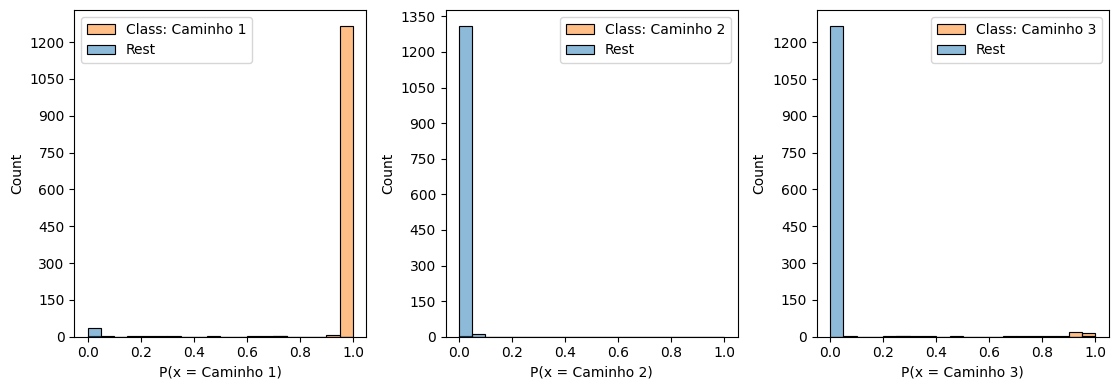

##############    DecisionTree    ################


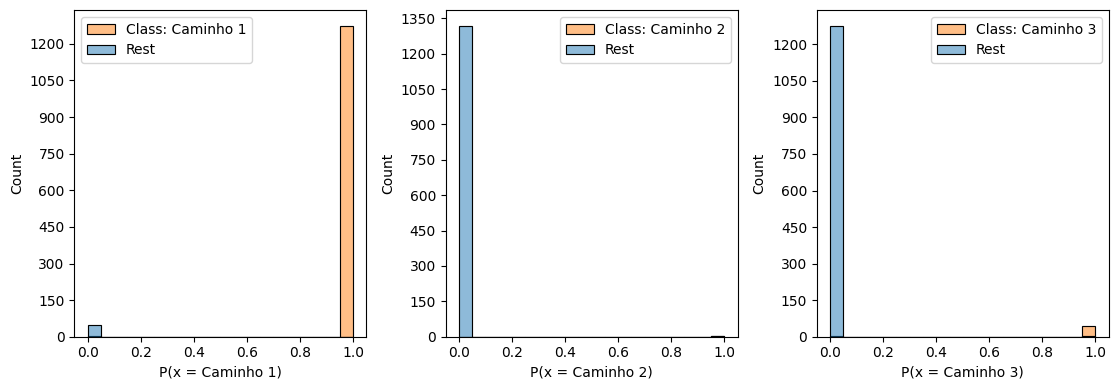

##############    ExtraTrees    ################


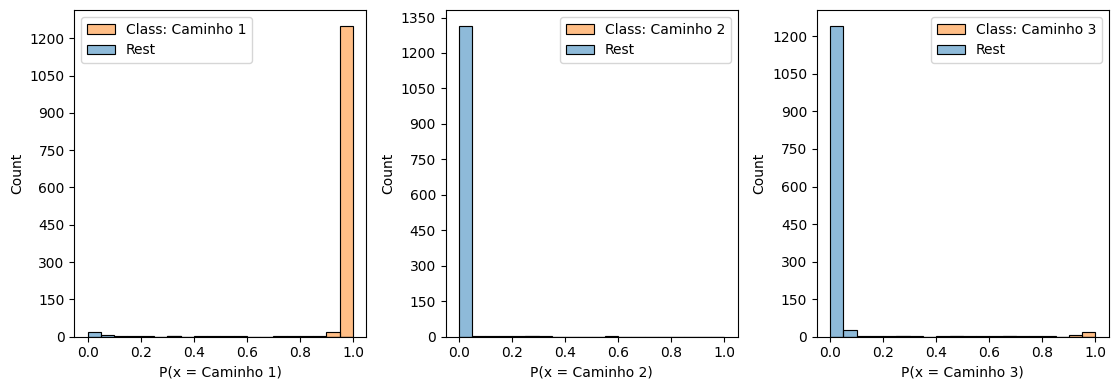

##############    RandomForest    ################


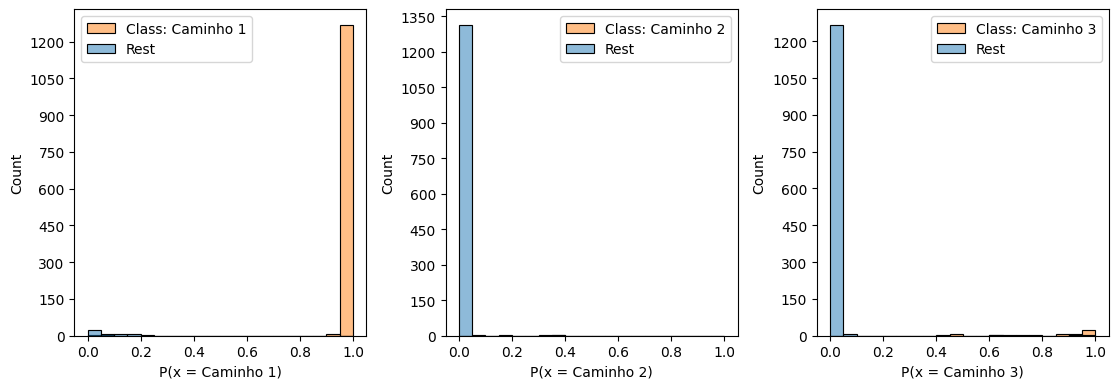

##############    GaussianNB    ################


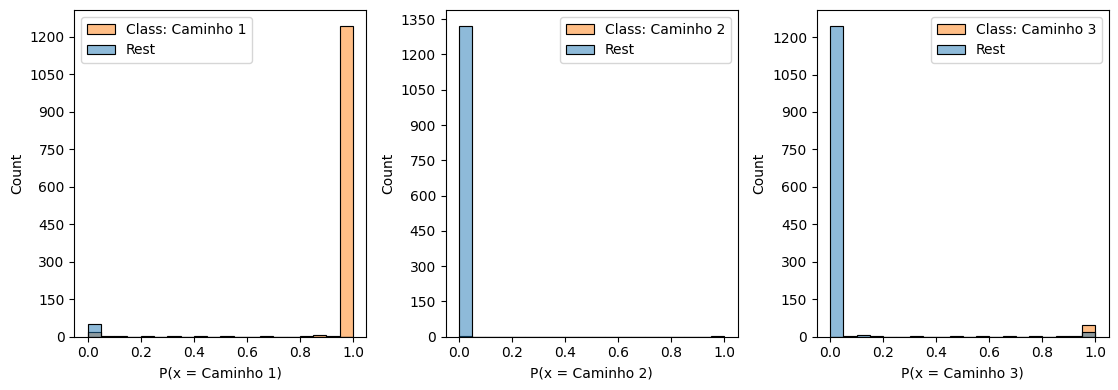

In [210]:
for key, values in y_predproba_dic.items():
    print(f"##############    {key}    ################")
    plot_Prob_Dist_OvR(routes_class,key,values,routes_label,title_str='',save_path=result_path,save_file='cross_val_prob-dist')

### Roc Curve

##############    LogisticRegression    ################


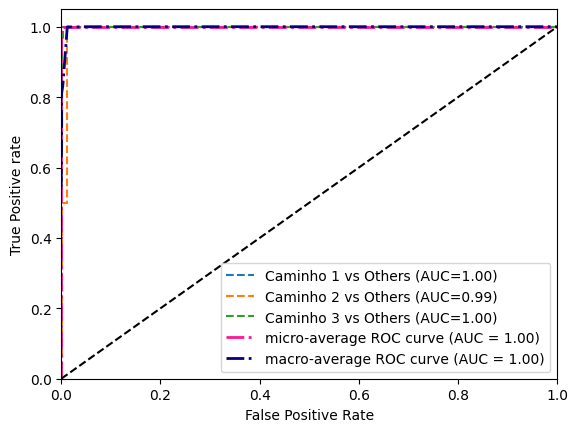

##############    KNeighbors    ################


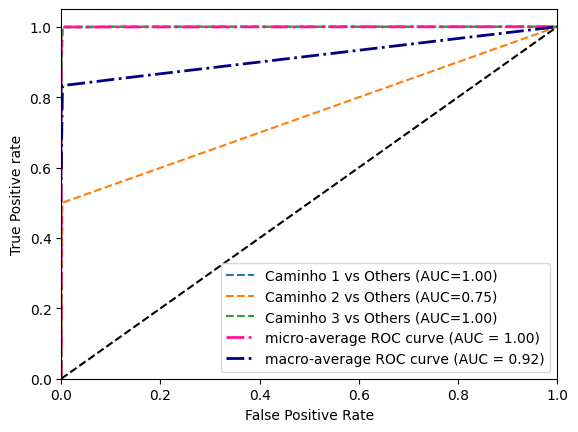

##############    svc    ################


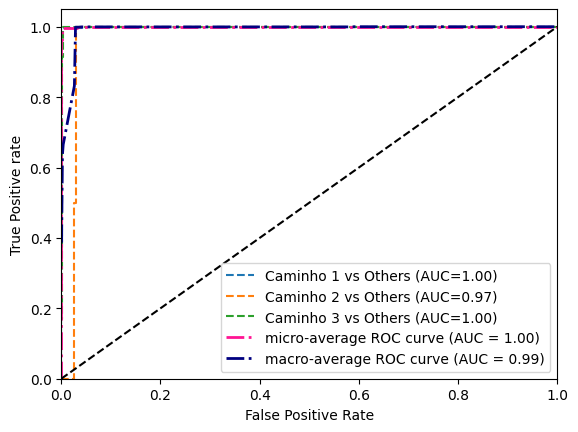

##############    DecisionTree    ################


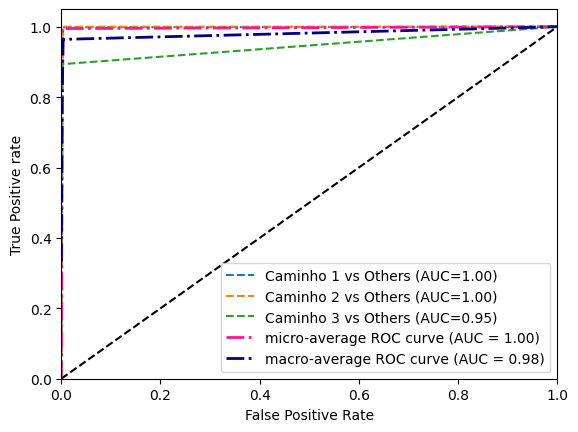

##############    ExtraTrees    ################


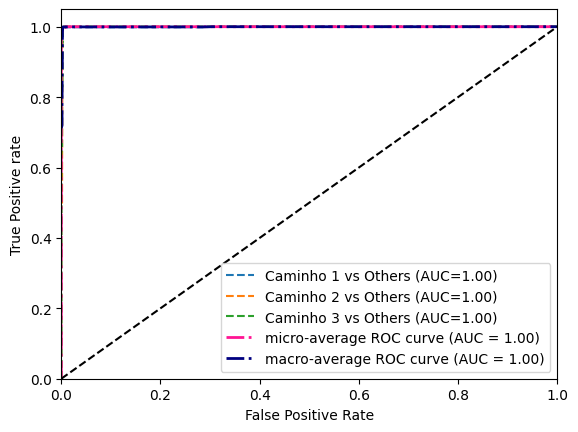

##############    RandomForest    ################


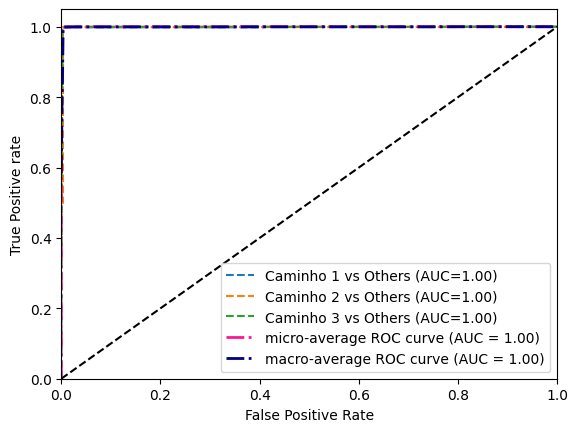

##############    GaussianNB    ################


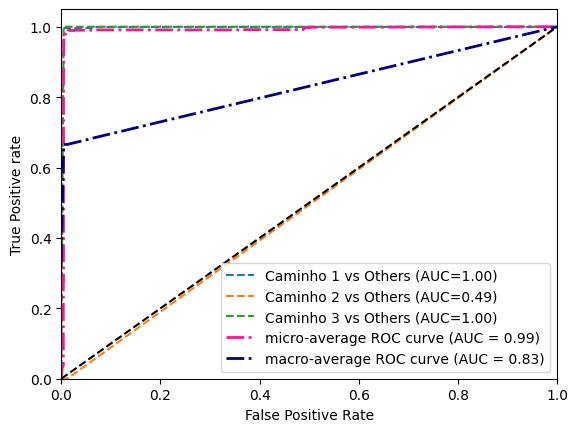

In [226]:
y_test_binarized = label_binarize(routes_label, classes=np.unique(routes_label))
for key, values in y_predproba_dic.items():
    print(f"##############    {key}    ################")
    plot_roc_curve(y_test_binarized,list(routes_class.keys()),key,values,title_str=key,save_path=result_path,save_file='cross_val_roc-curve')

# for key, values in y_predproba_dic.items():
#     print(f"##############    {key}    ################")
#     plot_roc_curve(routes_label,list(routes_class.keys()),key,values,title_str=key,save_path=result_path,save_file='cross_val_roc-curve')